<a href="https://colab.research.google.com/github/seungmindavid/Representational_Learning/blob/main/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network (GAN)

Discriminator: $\frac{1}{m}\sum^m_{i=1}[log D(x^{(i)}) + log(1-D(G(z^{(i)})))]$ where $z^{(i)}:$ Random noise


Generator: $\frac{1}{m}\sum^m_{i=1}log(1-D(G(z^{(i)})))$

$L_{GAN} = \min_G\max_D V(D,G) = \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1-D(G(z)))]$

In practice, Generator is trained to instead:
$\max_G \mathbb{E}_{z\sim p_z(z)}[log D(G(z))]$.

The prevalent occurrence of $D(G(z))=0$ initially arises from the fact that the logarithmic function $log(x)$ exhibits a more pronounced steepness when $x$ is equal to zero, as compared to the slope of $log(1-x)$.


In [1]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pathlib
import torchvision


# Loading Dataset (MNIST)
Batch size
- Train dataset: 1024 batch size
- Test dataset: 10 batch



In [2]:
batch_size_train = 1024
batch_size_test = 10

# mean and standard deviation for mnist dataset: 0.1307, 0.3081
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download= True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size = batch_size_test, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 24294030.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82799517.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37131106.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2228914.09it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Loss Construction
- Discriminator: $\text{min}_G \text{max}_D \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1-D(G(z)))]$, with fixed G (Generator).
- $L_{dis} = BCE(D(x), 1) + BCE(D(G(z)), 0)$


- Generator: $\text{max}_G\mathbb{E}_{z\sim p_{z}(z)}[log(D(G(z)))]$ which is equal to $\text{min}_G\mathbb{E}_{z\sim p_{z}(z)}[1-log(D(G(z)))]$ with fixed D
(Discriminator)
- $L_{gen} = -BCE(D(G(z)), 0) = BCE(D(G(z)), 1)$

- The rationale for transitioning the generator from a minimization objective to a maximization objective lies in the common observation that, initially, the discriminator typically exhibits superior performance over the generator. This phenomenon lead $D(G(z))$ to outproduce 0. Particularly, when $x=0$, $log(x)$ has steeper gradient than $log(1-x)$, which faciliates the more efficient training of the Generator.


In [3]:
BCE = nn.BCELoss()

# Building Discriminator & Generator
- [Linear → LeakyReLU] × 4 using increasing linear layer sizes, e.g., 128 → 256 → 512 → 1024 → (28 ∗ 28). LeakyReLU often replaces the ReLU non-linearity in direct generative models both in convolutional generators and fully connected generators.
- Generator: 128 → 256 → 512 → 1024 → (28 ∗ 28)
- Discriminator: (28 ∗ 28) → 1024 → 512 → 256 → 128 -> 1

In [4]:
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Linear(img_dim, 1024),
        nn.LeakyReLU(0.1),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.1),
        nn.Linear(512,256),
        nn.LeakyReLU(0.1),
        nn.Linear(256,128),
        nn.LeakyReLU(0.1),
        nn.Linear(128,1),
        nn.Sigmoid(),
    )
  def forward(self, x):
    return self.disc(x)

class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.gen = nn.Sequential(
        nn.Linear(z_dim, 128),
        nn.LeakyReLU(0.1),
        nn.Linear(128, 256),
        nn.LeakyReLU(0.1),
        nn.Linear(256,514),
        nn.LeakyReLU(0.1),
        nn.Linear(514,1024),
        nn.LeakyReLU(0.1),
        nn.Linear(1024, img_dim),
        nn.Tanh(),
    )
  def forward(self, x):
    return self.gen(x)



# Training GAN

In [5]:
# Save model
saved_params_path = "./saved_params_gan"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

# Hyperparameters
device = "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28*28*1 #784
num_epochs = 50

Gen_Loss = []
Dis_Loss = []

dis = Discriminator(image_dim).to(device)
dis_optim = optim.Adam(dis.parameters(), lr=lr)
gen = Generator(z_dim, image_dim).to(device)
gen_optim = optim.Adam(gen.parameters(), lr=lr)
fixed_noise = torch.randn((batch_size_train, z_dim)).to(device)

for epoch in range(num_epochs):
  for i, data in enumerate(train_loader, 0):
    real, labels = data
    real = real.view(-1, 784).to(device)
    batch_size = real.shape[0]

    # Train Discriminator
    noise = torch.randn(batch_size, z_dim).to(device)
    fake = gen(noise)
    D_x = dis(real).view(-1)
    L_dis_real = BCE(D_x, torch.ones_like(D_x))

    D_G_z = dis(fake).view(-1)
    L_dis_fake = BCE(D_G_z, torch.zeros_like(D_G_z))
    D_loss = (L_dis_real + L_dis_fake) /2
    dis.zero_grad()
    D_loss.backward(retain_graph=True)
    dis_optim.step()

    # Train Generator
    D_G_z = dis(fake).view(-1)
    G_loss = BCE(D_G_z, torch.ones_like(D_G_z))
    gen.zero_grad()
    G_loss.backward()
    gen_optim.step()
  print(f"Epoch [{epoch}/{num_epochs}]\
        Discriminator Loss: {D_loss.item():.4f}, loss G: {G_loss.item():.4f}")
  Gen_Loss.append(G_loss.item())
  Dis_Loss.append(D_loss.item())
  torch.save(dis.state_dict(), f'{saved_params_path}/discriminator_{epoch}.pth')
  torch.save(dis.state_dict(), f'{saved_params_path}/generator_{epoch}.pth')


Epoch [0/50]        Discriminator Loss: 0.5346, loss G: 0.4545
Epoch [1/50]        Discriminator Loss: 0.3525, loss G: 1.1294
Epoch [2/50]        Discriminator Loss: 0.7042, loss G: 0.3026
Epoch [3/50]        Discriminator Loss: 0.1150, loss G: 5.6204
Epoch [4/50]        Discriminator Loss: 0.4545, loss G: 1.5241
Epoch [5/50]        Discriminator Loss: 0.1099, loss G: 6.2085
Epoch [6/50]        Discriminator Loss: 0.0113, loss G: 6.1175
Epoch [7/50]        Discriminator Loss: 0.1261, loss G: 3.6211
Epoch [8/50]        Discriminator Loss: 0.1745, loss G: 5.2181
Epoch [9/50]        Discriminator Loss: 0.4136, loss G: 6.1641
Epoch [10/50]        Discriminator Loss: 0.0330, loss G: 7.4071
Epoch [11/50]        Discriminator Loss: 0.1949, loss G: 4.2762
Epoch [12/50]        Discriminator Loss: 0.0135, loss G: 8.7049
Epoch [13/50]        Discriminator Loss: 0.0077, loss G: 6.3140
Epoch [14/50]        Discriminator Loss: 0.1603, loss G: 7.9991
Epoch [15/50]        Discriminator Loss: 0.0454, l

# Plotting Discriminator vs Generator

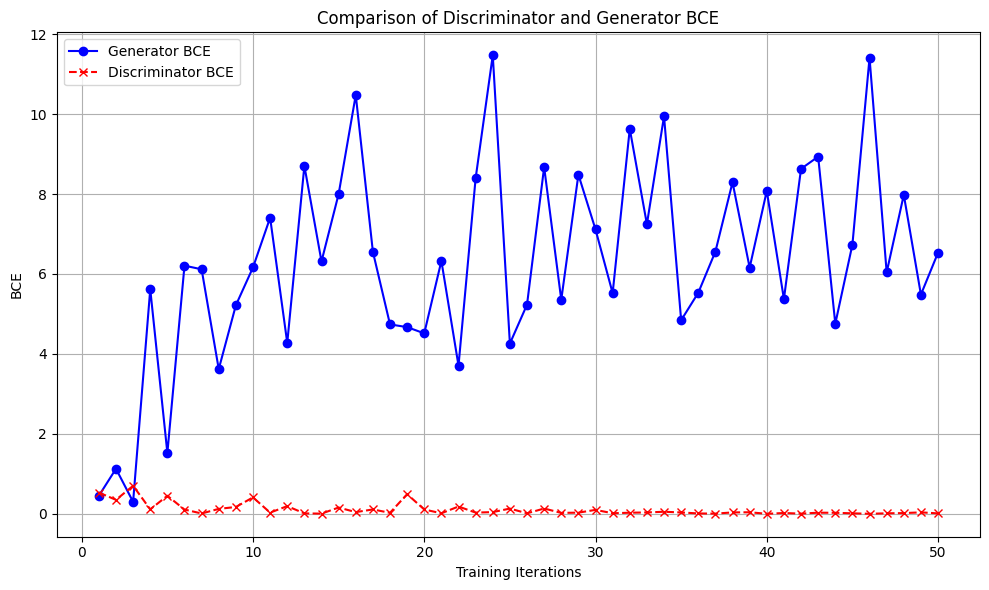

In [6]:
import matplotlib.pyplot as plt

# Define the x-axis (training iteration or epoch numbers)
iterations = range(1, len(Gen_Loss) + 1)

# Plot the loss curves for both models
plt.figure(figsize=(10, 6))
plt.plot(iterations, Gen_Loss, label='Generator BCE', marker='o', linestyle='-', color='b')
plt.plot(iterations, Dis_Loss, label='Discriminator BCE', marker='x', linestyle='--', color='r')

# Add labels and a legend
plt.xlabel('Training Iterations')
plt.ylabel('BCE')
plt.title('Comparison of Discriminator and Generator BCE')
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

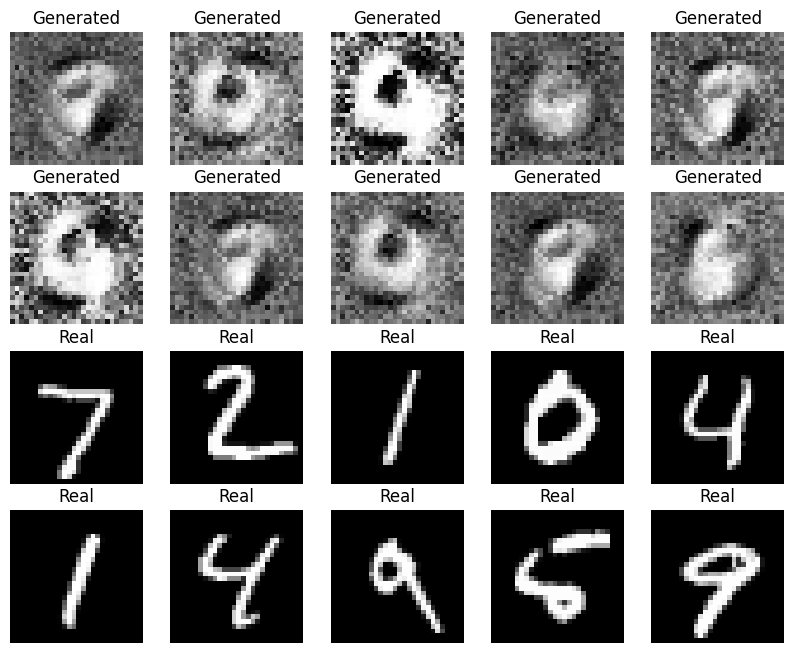

In [7]:
#gen.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))
gen.eval()

fixed_noise = torch.randn((batch_size_test, z_dim)).to(device)
generated_images = gen(fixed_noise)

real_images, _ = next(iter(test_loader))
real_images = real_images.view(real_images.size(0), -1).numpy()

import matplotlib.pyplot as plt

# Display generated and real images in a 4x4 grid
plt.figure(figsize=(10, 10))

for i in range(20):
    plt.subplot(5, 5, i + 1)
    if i < 10:
        plt.imshow(generated_images[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
        plt.title('Generated')
    else:
        plt.imshow(real_images[i - 10].reshape(28, 28), cmap='gray')
        plt.title('Real')
    plt.axis('off')

